## Sarcasm Detection

Dataset Source: https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection

##### Import Necessary Libraries

In [0]:
import pyspark
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
import pyspark.sql.functions as F
from pyspark.ml import Pipeline

import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *

import pandas as pd

##### Display Versions of Relevant Languages, Libraries, etc.

In [0]:
print("Spark NLP version".ljust(22), sparknlp.version())
print("Apache Spark version:".ljust(22), spark.version)
print("Pandas version:".ljust(22), pd.__version__)

Spark NLP version      4.2.4
Apache Spark version:  3.3.1
Pandas version:        1.4.2


#### Functions Used Throughout Project

##### Function to Ingest Dataset

In [0]:
def ingest_json_data(file_location: str) -> pyspark.sql.dataframe.DataFrame:
    '''
    This function returns the dataset that correlates to the json
    file that is passed into this function. The dataset also has
    the schema applied to it.
    '''
    file_type = "json"
    
    dataset = spark.read.format(file_type)\
        .load(file_location)
    
    return dataset

##### Metrics Evaluation Function

In [0]:
def metrics_eval(label: pd.DataFrame, \
                 prediction: pd.DataFrame, \
                 model_name: str, \
                 label_values: [str]) -> None:
    '''
    This function calculates & displays metrics.
    '''
    # Import necessary libraries & modules necessary for this function to successfully complete.
    from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay  
    
    print("--------------------------------------------------------------------------------")
    print(f"The {model_name} Model".center(80))
    print("--------------------------------------------------------------------------------")
    print(f"Classification Report for the {model_name} Model:".center(80))
    print("--------------------------------------------------------------------------------")
    
    # Calculate & display classification report
    report = classification_report(label, prediction, target_names=label_values, zero_division=1)
    print('\n', report)
    print("--------------------------------------------------------------------------------")
    
    # Calculate & display confusion matrix
    print(f"Confusion Matrix for the {model_name} Model:".center(80))
    cm = confusion_matrix(label, prediction)
    dist = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_values)
    dist.plot()
    
    print("--------------------------------------------------------------------------------")
     

#### Prepare Data for Training

##### Ingest Dataset & Preprocess Dataset

In [0]:
data_file = "/FileStore/tables/Sarcasm_Headlines_Dataset_v2.json" # This is the location of the file used for this project

df = ingest_json_data(data_file) # This function returns the dataset in the PySpark DataFrame data type

df = df.drop("article_link") # Drop unnecessary feature

df = df.withColumnRenamed("headline", "text")\
        .withColumnRenamed("is_sarcastic", "labels") # Update the feature & class names to more standard values to make it easier to follow code

df = df.withColumn("labels", df.labels.cast(StringType()).alias("labels")) # Cast labels to StringType so that data. types match for metrics evaluation

df = df.na.drop(how='any') # I dropped samples with any missing features since the options are basic (which could lead to skewed results)

df = df.dropDuplicates() # Dataset is large enough both before and after dropping duplicates to just eliminate them altogether

df.printSchema() # This & the display function are used to both visualize edits made & check for obvious other edits that need to be made

display(df)

root
 |-- text: string (nullable = true)
 |-- labels: string (nullable = true)



text,labels
naacp demands less minority representation on upn,1
tom hanks brags how 'smokin' hot' rita wilson is after 29 years of marriage,0
drunk driver in the zone,1
my life in soaps,0
angry lumberjack demands hearty breakfast,1
image vs. substance in your self-made journey,0
mountain lion tracked by scientists is found dead near malibu road,0
"stop talking about 'screen time,' start thinking about screen use",0
"this common nighttime habit is giving you wrinkles, study says",0
how boehner can 'clean house': one sentence to prevent government shutdowns forever,0


Output can only be rendered in Databricks

##### Split Dataset Into Training & Testing Datasets

In [0]:
train_ds, test_ds = df.randomSplit(weights=[0.80, 0.20], seed=42) # Decided on an 80/20 split

print(f"There are {train_ds.count()} samples in the training dataset.") # Print out results for reference
print(f"There are {test_ds.count()} samples in the testing dataset.") # Print out results for reference

There are 22831 samples in the training dataset.
There are 5672 samples in the testing dataset.


#### Build & Run Model

##### Build Pipeline Stages

In [0]:
# Document Assembler to retrieve necessary feature for pipeline
doc = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("doc")

# Applying USE Sentence Encoder for this analysis
use = UniversalSentenceEncoder.pretrained()\
    .setInputCols("doc") \
    .setOutputCol("sentence_embeddings")

# Deep Learning Classifier is used
clf = ClassifierDLApproach()\
                    .setInputCols("sentence_embeddings")\
                    .setOutputCol("class")\
                    .setLabelColumn("labels")\
                    .setMaxEpochs(20)\
                    .setEnableOutputLogs(True)

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


##### Build Pipeline

In [0]:
clf_pipe = Pipeline(
    stages = [
        doc,
        use,
        clf
    ]) # Concatenate pipeline stages in proper order & set them as the stages for pipeline

##### Fit Pipeline to Training Dataset

In [0]:
sarcasm_clf_model = clf_pipe.fit(train_ds) # fit pipeline to training dataset to create model

#### Evaluate Model

##### Inference: Generate Predictions Using Testing Dataset

In [0]:
predictions = sarcasm_clf_model.transform(test_ds) # transform testing dataset using model created to generate predictions

##### Prepare Predictions for Metrics Evaluation Function

In [0]:
preds = (predictions.select(\
                            F.col("labels").alias("ground_truth"), \
                            F.col("class.result").alias("predictions"))\
        ).toPandas() # Only retrieve needed features for metrics evaluation

preds['predictions'] = preds['predictions'].apply(lambda x : x[0]) # Return the first item in array from prediction column

##### Evaluate Predictions

--------------------------------------------------------------------------------
                  The Sarcasm Detection (Classification) Model                  
--------------------------------------------------------------------------------
    Classification Report for the Sarcasm Detection (Classification) Model:     
--------------------------------------------------------------------------------

               precision    recall  f1-score   support

 Not Sarcasm       0.89      0.90      0.89      2956
     Sarcasm       0.89      0.88      0.88      2716

    accuracy                           0.89      5672
   macro avg       0.89      0.89      0.89      5672
weighted avg       0.89      0.89      0.89      5672

--------------------------------------------------------------------------------
       Confusion Matrix for the Sarcasm Detection (Classification) Model:       
--------------------------------------------------------------------------------


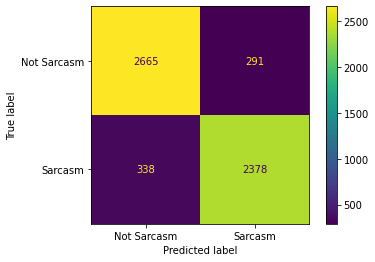

In [0]:
labels_converter = ["Not Sarcasm", "Sarcasm"] # Labels to use

# Call to metrics evaluation (UDF) function
metrics_eval(preds["ground_truth"], preds["predictions"], "Sarcasm Detection (Classification)", labels_converter) 

##### Stop Spark Session

In [0]:
spark.stop()

### Notes & Other Takeaways From This Project
****
- Since this was an easier project, I took the time to further refine some of my user-defined functions.
****